In [47]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import numpy as np
import pandas as pd
import os, random
from glob import glob
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [48]:
import torch
import torch.nn

print(torch.cuda.is_available())
print(torch.rand(5, 3, device='cuda'))


True
tensor([[0.6967, 0.9192, 0.2290],
        [0.2741, 0.5848, 0.7920],
        [0.9756, 0.6859, 0.5466],
        [0.2876, 0.0638, 0.7200],
        [0.4771, 0.6933, 0.3808]], device='cuda:0')


In [49]:
# import os

# base_path = 'C:/Users/User/data/result/'
# num_skipped = 0
# for folder_name in ("Porpoise", "Mink"):
#     folder_path = os.path.join(base_path, folder_name)
# for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print("Deleted %d images" % num_skipped)

In [50]:
image_size = (64, 64)
batch_size = 16
input_shape = image_size + (3,)
num_classes = 2

data_url = 'C:/Users/User/data/result/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_url,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)



Found 4459 files belonging to 2 classes.
Using 3568 files for training.
Using 891 files for validation.


In [51]:
class_names = train_ds.class_names
print(class_names)

['Mink', 'Porpoise']


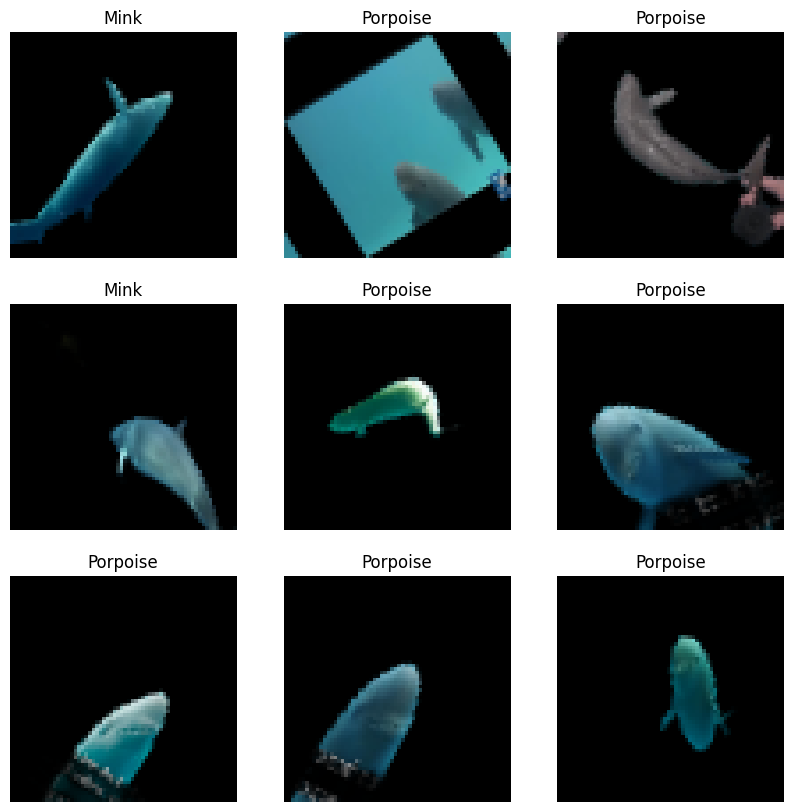

In [74]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

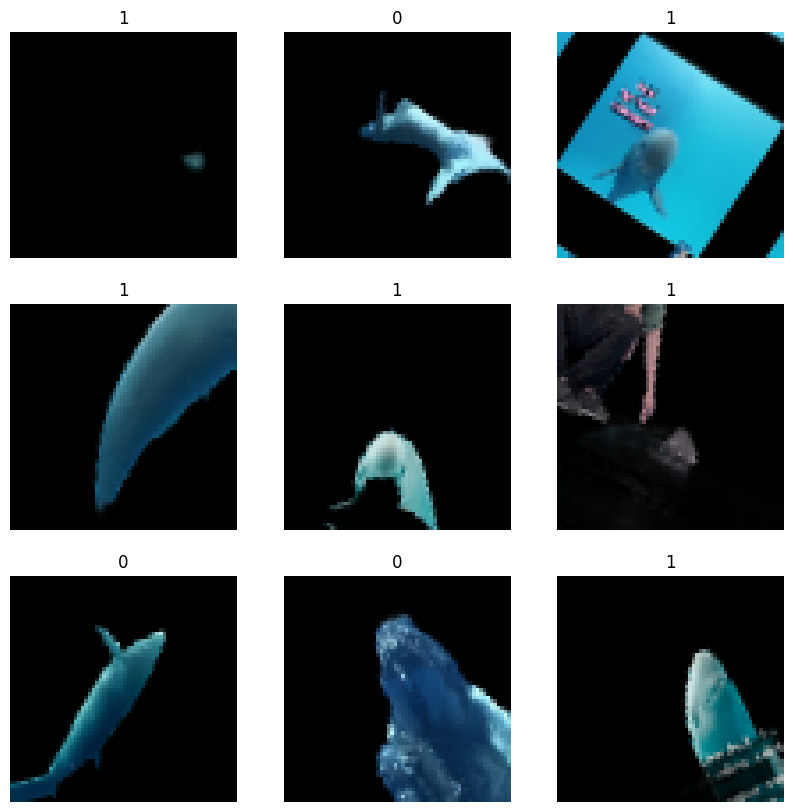

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [53]:

#데이터 증강
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

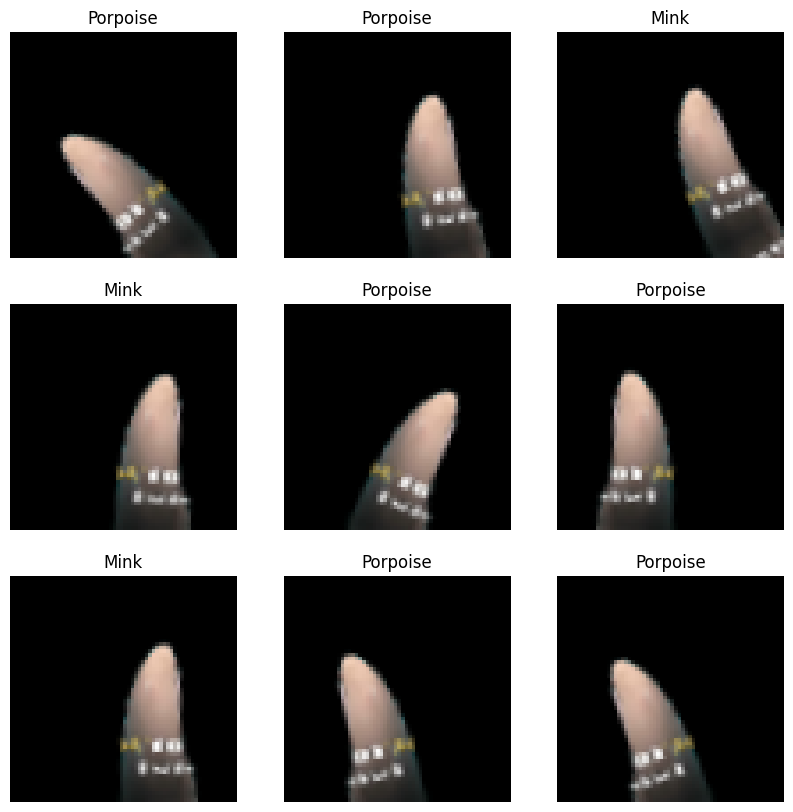

In [73]:
plt.figure(figsize=(10, 10))
   

for images, _, in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [55]:
#과적합 방지, 모델 학습성능 향상

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

Ellipsis

In [56]:
#gpu 사용 시 
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [57]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    
    # activation = 'softmax'
    # units=num_classes

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)


keras.utils.plot_model(model, show_shapes=True)



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [58]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("test-6-save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    #optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss="binary_crossentropy", #binary_crossentropy   mean_squared_error  3개 이상의 클래스 사용 시 binary 대신 categorical 사용
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    workers=5,
    use_multiprocessing=True,
)

Epoch 1/20
223/223 [==============================] - 61s 259ms/step - loss: 0.4389 - accuracy: 0.8201 - val_loss: 0.6303 - val_accuracy: 0.7172
Epoch 2/20
223/223 [==============================] - 58s 257ms/step - loss: 0.3177 - accuracy: 0.8714 - val_loss: 0.7113 - val_accuracy: 0.7172
Epoch 3/20
223/223 [==============================] - 58s 257ms/step - loss: 0.2734 - accuracy: 0.8857 - val_loss: 1.0040 - val_accuracy: 0.5735
Epoch 4/20
223/223 [==============================] - 57s 253ms/step - loss: 0.2167 - accuracy: 0.9145 - val_loss: 0.3955 - val_accuracy: 0.8373
Epoch 5/20
223/223 [==============================] - 56s 251ms/step - loss: 0.2156 - accuracy: 0.9156 - val_loss: 0.1586 - val_accuracy: 0.9416
Epoch 6/20
223/223 [==============================] - 56s 249ms/step - loss: 0.1858 - accuracy: 0.9285 - val_loss: 0.1553 - val_accuracy: 0.9383
Epoch 7/20
223/223 [==============================] - 56s 252ms/step - loss: 0.1599 - accuracy: 0.9386 - val_loss: 0.2942 - val_ac

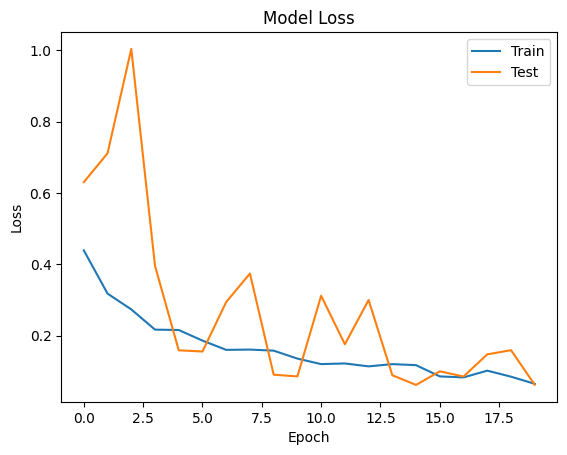

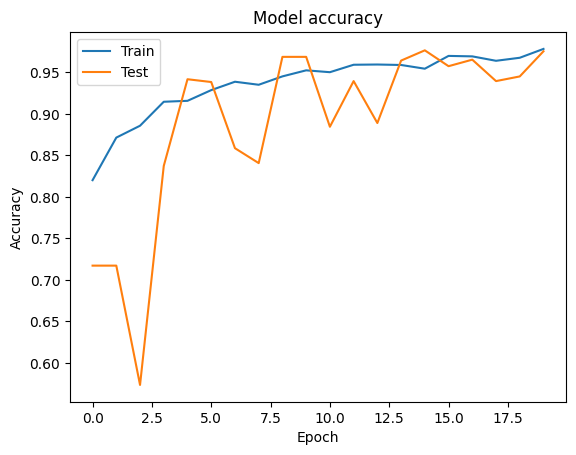

In [59]:

def plt_show_loss(history) :
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

def plt_show_acc(history) :
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

plt_show_loss(history)
plt.show()

plt_show_acc(history)
plt.show()

56/56 [==============================] - 5s 82ms/step
[100.0]


TypeError: '_PrefetchDataset' object is not subscriptable

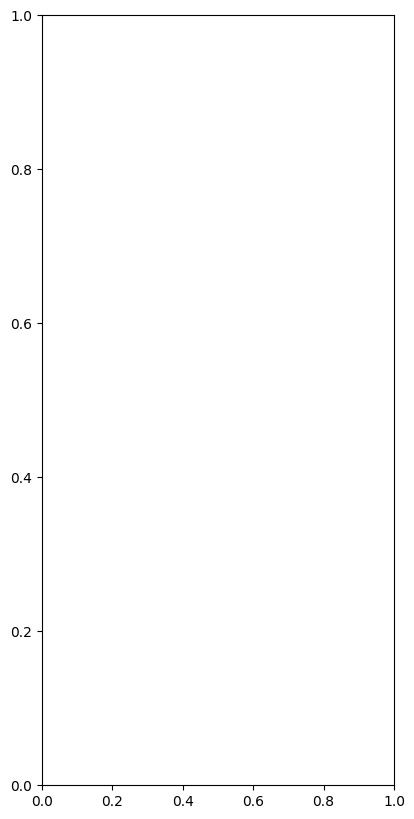

In [87]:
import os
import glob

# 폴더 내의 모든 이미지 파일 경로 가져오기
folder_path = "C:Users/User/data/test"  # 이미지 폴더 경로
image_files = glob.glob(os.path.join(folder_path, "*.jpg"))  # jpg 확장자를 가진 이미지 파일들의 경로 리스트

for img_path in image_files:
    # 이미지 불러오기
    img = keras.utils.load_img(img_path, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # 모델로 예측하기
    predictions = model.predict(img_array)
    class_probs = [prob*100 for prob in predictions[0]]

    # 예측 결과 시각화하기
    plt.imshow(img_array[0].numpy().astype("uint8"))
    plt.title(f"This image is {class_probs[0]:.2f}% {class_names[0]}")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


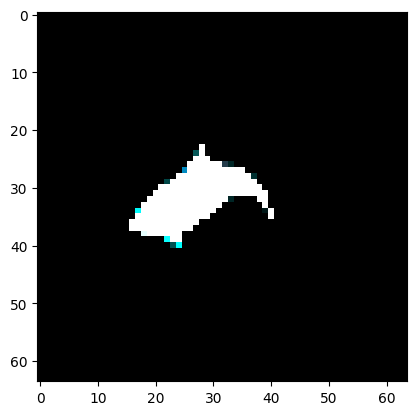

TypeError: Image data of dtype object cannot be converted to float

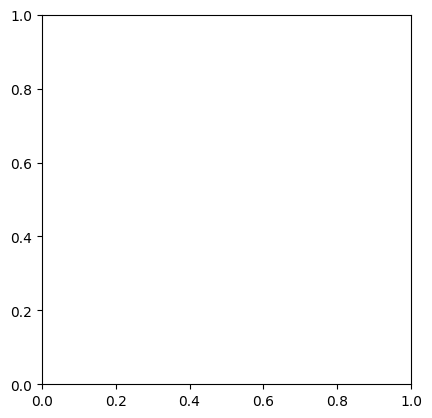

In [90]:
img = keras.utils.load_img(
    "C:/Users/User/Desktop/bigdata/imgs/test/3.jpg", target_size=image_size
)
for img, label in val_ds.take(1):
    plt.imshow(img[0].numpy())  # 첫 번째 이미지 선택
    plt.show()

plt.imshow(val_ds)

img_array = keras.utils.img_to_array(val_ds)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# 모델로부터 예측을 수행하고, 각 클래스에 대한 확률 출력
predictions = model.predict(img_array)
#class_names = ['Delphinus', 'Mink', 'Porpoise']

# 각 클래스별 확률 계산
class_probs = [prob*100 for prob in predictions[0]]
print(predictions)
# 결과 출력

# 2개 이상의 차원으로 학습 시켰을 때 예측 결과
#core0 = class_probs[0]
#score1 = class_probs[1]
#print(f"This image is {score0:.2f}% {class_names[0]} and {score1:.2f}% {class_names[1]}")
#print(f"This image is {score0:.2f}% {class_names[0]}")

# score0 = float(predictions[0][0])
# score1 = float(predictions[0][1])
# print(f"This image is {100 * score0:.2f}% {class_names[0]} and {100 * score1:.2f}% {class_names[1]}")

# 1차원으로 학습 시켰을때 예측 결과
print(f"This image is {class_probs[0]:.2f}% {class_names[0]}")
# print(f"This image is {class_probs[2]:.2f}% {class_names[2]}, {class_probs[1]:.2f}% {class_names[1]}, {class_probs[0]:.2f}% {class_names[0]}.")

(420, 600)


InvalidArgumentError: Graph execution error:

Detected at node model_3/conv2d_12/BiasAdd defined at (most recent call last):
  File "c:\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Python310\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "c:\Python310\lib\asyncio\base_events.py", line 1899, in _run_once

  File "c:\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\User\AppData\Local\Temp\ipykernel_5140\3010006857.py", line 14, in <module>

  File "c:\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Python310\lib\site-packages\keras\src\engine\training.py", line 2631, in predict

  File "c:\Python310\lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function

  File "c:\Python310\lib\site-packages\keras\src\engine\training.py", line 2401, in step_function

  File "c:\Python310\lib\site-packages\keras\src\engine\training.py", line 2389, in run_step

  File "c:\Python310\lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step

  File "c:\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Python310\lib\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "c:\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Python310\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Python310\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 311, in call

input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model_3/conv2d_12/BiasAdd}}]] [Op:__inference_predict_function_143944]

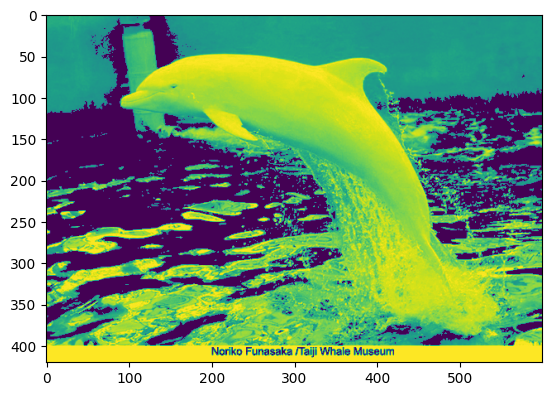

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

test_pic = plt.imread("C:/Users/User/Desktop/bigdata/imgs/test/3.jpg")
test_pic = test_pic[:,:,0]
test_pic = (test_pic > 125) * test_pic
test_pic = test_pic.astype('float32') / 255.

plt.imshow(test_pic)

print(test_pic.shape)
test_pic = test_pic.reshape((1, 420, 600, 1))

print("The Answer is : ", model.predict(test_pic))